In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [50]:
# Lista de tickets a procesar
tickets = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]

# Inicializar una lista para almacenar los DataFrames
dfs = []
i = 0

# Iterar sobre cada ticket y cargar los datasets
for ticket in tickets:
    # Cargar el conjunto de datos para cada ticket
    df = pd.read_csv(f'../Data/Global_Data_{ticket}.csv', parse_dates=['Date'])
    
    # Añadir una columna 'unique_id' para identificar cada ticket
    df['unique_id'] = i
    i += 1
    # Agregar el DataFrame a la lista
    dfs.append(df)

# Unir todos los DataFrames en uno solo
df = pd.concat(dfs, ignore_index=True)

# Definir las características a utilizar
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal', 
            'weighted_sentiment', 'weighted_sentiment_lag2','weighted_sentiment_lag3',
            'weighted_sentiment_change','tweet_count']

# Filtrar el DataFrame con las columnas de interés
df_filt = df[['Date', 'unique_id'] + features]

# Asegurarse de que los datos estén ordenados por fecha
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Crear un índice de fechas completo para cada 'unique_id' (empresa)
full_idx = pd.date_range(start=df_filt['Date'].min(), end=df_filt['Date'].max(), freq='D')

# Reindexar el DataFrame para cada 'unique_id' e incluir todas las fechas
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    # Filtrar por empresa
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    
    # Crear un índice completo para esta empresa
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    
    # Reindexar el DataFrame para esta empresa e incluir todas las fechas
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    
    # Asignar el `unique_id` correctamente para los días faltantes
    df_ticker_reindexed['unique_id'] = unique_id  # Asignar el 'unique_id' a los días faltantes
    
    # Añadir la empresa reindexada a la lista
    dfs_with_full_dates.append(df_ticker_reindexed)

# Unir todos los DataFrames con las fechas completas
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar los valores faltantes en las columnas numéricas utilizando interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

df_scaled = pd.DataFrame(df_filt_full[features], 
                         columns=features, 
                         index=df_filt_full.index)

# Reemplazar las columnas originales por las escaladas
df_filt_full[features] = df_scaled

# Renombrar columnas para el modelo
df = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

df


,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,MACD,MACD_signal,weighted_sentiment,weighted_sentiment_lag2,weighted_sentiment_lag3,weighted_sentiment_change,tweet_count
0,2016-10-19,0,-1.629349,-1.631662,-1.638870,-1.697018,-0.776917,-1.829200,-1.855572,-0.392399,0.135975,0.168380,-1.468979,1.000000,0.445958,0.001222,1.000000
1,2016-10-20,0,-1.630826,-1.633271,-1.648981,-1.628377,-0.453567,-1.824075,-1.852979,0.124746,0.126238,0.162750,-1.468979,-1.000000,1.000000,0.001222,1.000000
2,2016-10-21,0,-1.627198,-1.629314,-1.646587,-1.623832,-0.465167,-1.821436,-1.851400,0.155823,0.122409,0.159302,-0.726177,-0.500000,0.500000,0.266256,1.250000
3,2016-10-22,0,-1.623569,-1.625357,-1.644192,-1.619288,-0.476768,-1.818797,-1.849821,0.186900,0.118581,0.155854,0.016625,0.000000,0.000000,0.531290,1.500000
4,2016-10-23,0,-1.619941,-1.621400,-1.641797,-1.614744,-0.488368,-1.816158,-1.848242,0.217977,0.114752,0.152405,0.759427,0.500000,-0.500000,0.796324,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2019-12-26,4,2.226812,2.225385,2.184029,2.229922,-1.084112,2.039065,2.040064,1.545804,2.017920,1.860707,0.075812,0.000000,0.279935,1.215572,5.000000
5836,2019-12-27,4,2.237172,2.236100,2.214109,2.260488,-0.728459,2.053576,2.049456,1.714978,2.108218,1.953535,-0.142198,-1.000000,0.000000,-0.155307,6.000000
5837,2019-12-28,4,2.220858,2.219227,2.207628,2.241975,-0.791338,2.058159,2.052462,1.428697,2.079068,1.971899,-0.145301,-0.666667,0.001985,-0.195401,6.333333
5838,2019-12-29,4,2.204544,2.202355,2.201148,2.223462,-0.854216,2.062742,2.055468,1.142417,2.049917,1.990263,-0.148405,-0.333333,0.003970,-0.235494,6.666667


In [51]:
# Dividir en conjunto de entrenamiento y prueba
train = df[df['ds'] <= '2019-09-30']
test = df[(df['ds'] > '2019-09-30')].reset_index(drop=True)


In [52]:
# Lista de variables exógenas
futr_exog_list = ['Open', 'High', 'Low', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 
                  'MACD_signal', 'weighted_sentiment', 'weighted_sentiment_lag2', 'weighted_sentiment_lag3',
                  'weighted_sentiment_change', 'tweet_count']

# Inicializar los modelos a evaluar
models = [
    # Modelo TFT (Temporal Fusion Transformer)
    TFT(
        h=7,
        input_size=20,
        hidden_size=128,
        dropout=0.1,
        n_head=16,  # Número de cabezales en la atención
        attn_dropout=0.1,  # Dropout en la capa de atención
        grn_activation='ReLU',  # Activación en la GRN (Gated Residual Network)
        rnn_type="LSTM",  # Tipo de RNN
        n_rnn_layers=6,  # Número de capas en la RNN
        one_rnn_initial_state=False,  # Estado inicial diferente en cada capa RNN
        futr_exog_list=futr_exog_list,
        loss=MAE(),
        scaler_type='robust',
        learning_rate=1e-3,
        max_steps=200,
        batch_size=128,
        step_size=1
    ),

]

# Crear el objeto NeuralForecast y ajustar el modelo
nf = NeuralForecast(
    models=models,
    freq='D'  # Frecuencia diaria
)

Seed set to 1


In [53]:
nf.fit(df=train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 3.8 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 4.1 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 250 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.593    Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


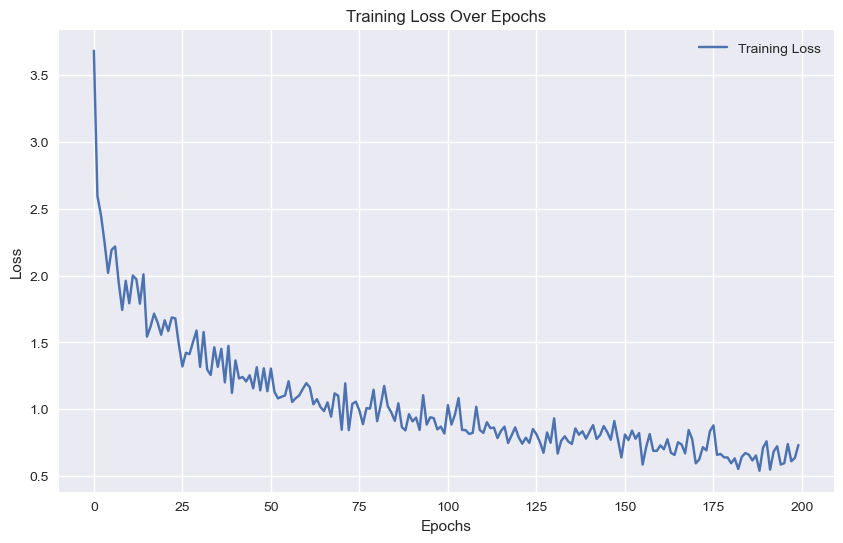

In [54]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Evaluación del Modelo

In [55]:
# Realizar predicciones utilizando el conjunto de prueba y las variables exógenas futuras
forecasts = nf.predict(futr_df=test)

c:\Users\pmyoe\anaconda3\Lib\site-packages\neuralforecast\core.py:904: UserWarning: Dropped 420 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [56]:
y_test = test[(test['ds'] > '2019-09-30') & (test['ds'] <= '2019-10-07')]['y']

y_pred = forecasts['TFT'].values

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')


MAE: 0.02995117947297861
MSE: 0.0015095557383012625
RMSE: 0.03885300166398038
R2: 0.9982354722365725


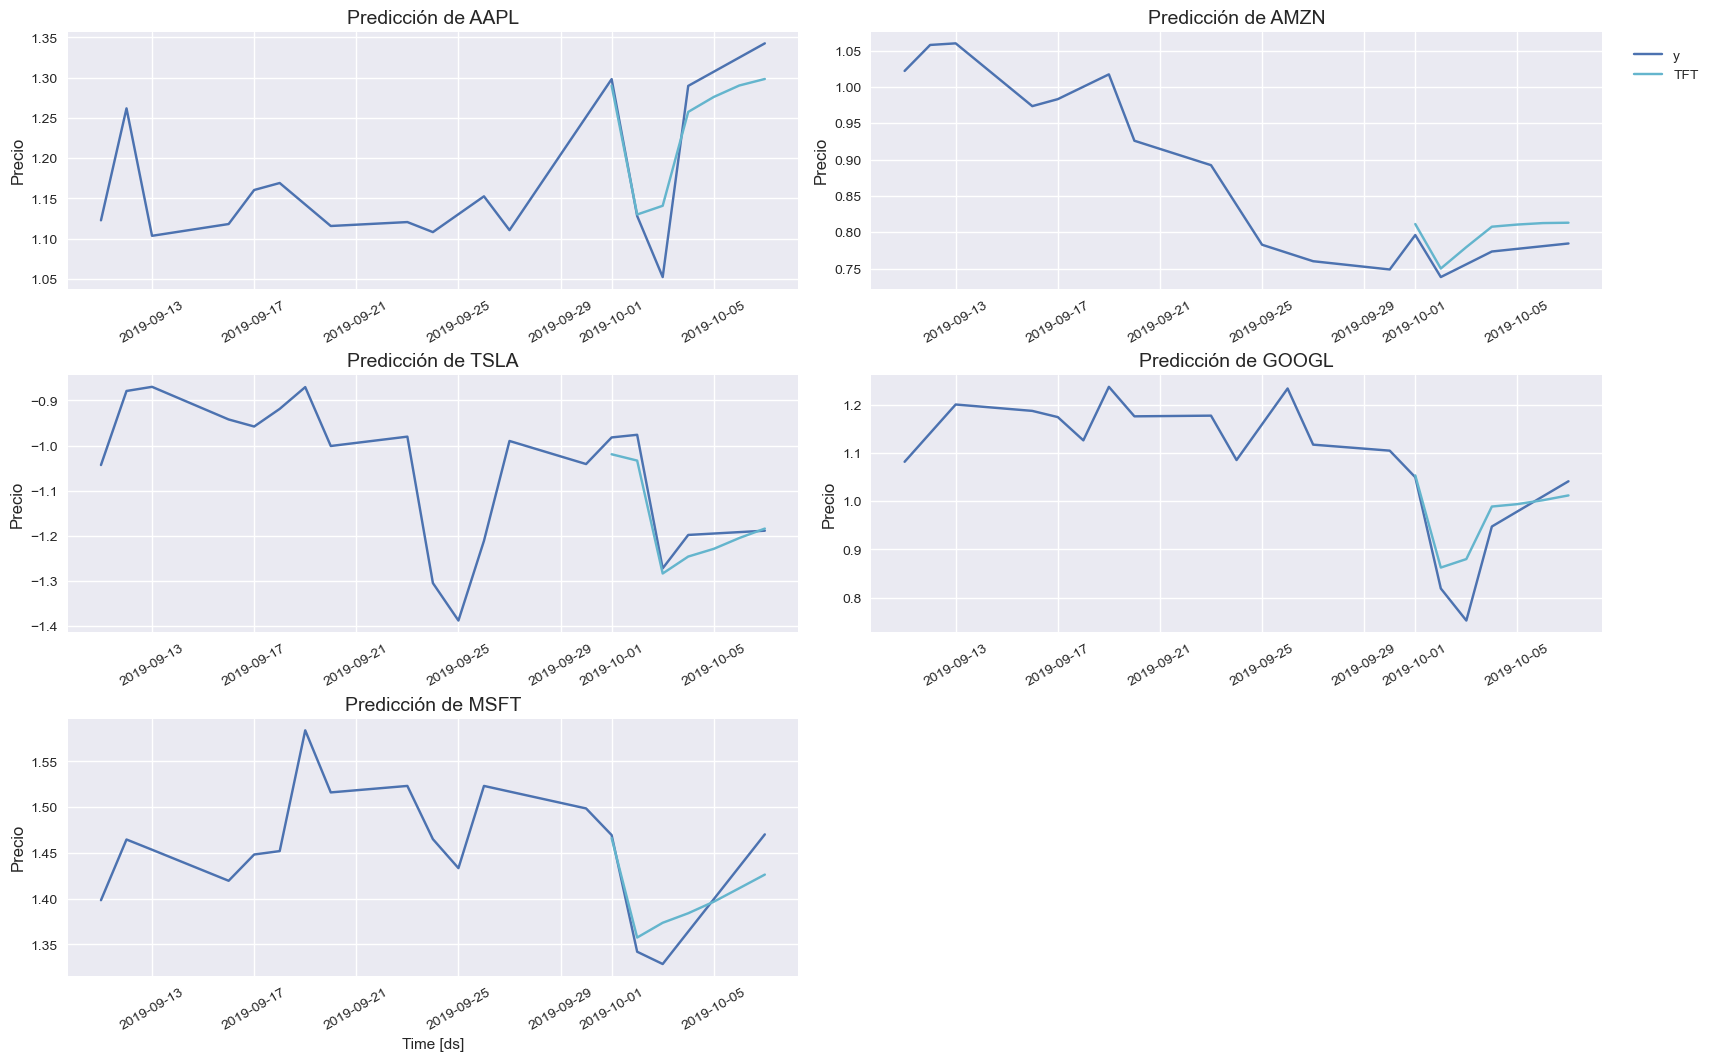

In [57]:
# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

# Filtrar los datos para el rango de fechas especificado
df_filtered = df[(df['ds'] > '2019-09-10') & (df['ds'] <= '2019-10-07')]


# Graficar con plot_series (la función retorna una figura, no un par de valores)
fig = plot_series(
    df_filtered,         # Datos reales
    forecasts_df=forecasts,  # Predicciones
    engine='matplotlib',     # Usar matplotlib como motor de gráficos
    id_col='unique_id',      # Columna que identifica las series (empresas)
    time_col='ds',           # Columna de fechas
    target_col='y',          # Columna de la variable objetivo
    plot_random=False,       # No graficar aleatoriamente
)

# Diccionario que mapea unique_id con nombres de empresas
empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}  # Ejemplo

# Acceder a los ejes y añadir títulos
# Acceder a los ejes y añadir títulos
for ax, unique_id in zip(fig.axes, forecasts['unique_id'].unique()):
    # Obtener el nombre de la empresa desde el diccionario
    nombre_empresa = empresa_dict.get(unique_id, "Empresa Desconocida")  # Mapeo al nombre de la empresa
    
    # Establecer título con el nombre de la empresa
    ax.set_title(f"Predicción de {nombre_empresa}", fontsize=14)
    
    # Cambiar el título del eje y
    ax.set_ylabel('Precio', fontsize=12)

# Mostrar la gráfica
fig

## Validación del Modelo

In [58]:
cv_result = nf.cross_validation(df=train, n_windows=4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 3.8 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 4.1 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 250 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.593    Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [59]:
# Calcular las métricas de cada empresa
metrics = []

empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Agrupar por empresa (unique_id)
for empresa_id, group in cv_result.groupby('unique_id'):
    y_true = group['y']
    y_pred = group['TFT']
    
    # Calcular MAE, RMSE, MAPE para cada empresa
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true,y_pred)
    
    # Guardar los resultados
    metrics.append({
        'Empresa': empresa_dict[empresa_id],
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics)

# Mostrar las métricas
print(metrics_df)

  Empresa       MAE      RMSE      MAPE        R2
0    AAPL  0.013830  0.015363  1.213066  0.796944
1    AMZN  0.014954  0.020821  1.905472  0.863374
2    TSLA  0.036008  0.044624  3.180387  0.920003
3   GOOGL  0.016822  0.020480  1.479792  0.814002
4    MSFT  0.009211  0.017526  0.632297  0.703318
